In [1]:
from copy import deepcopy
from functools import reduce
import unittest
import sys
sys.path.append('..')
from ktools.modelling.ktools_models.pytorch_nns.ffn_pytorch_embedding_model import FFNPytorchEmbeddingModel
import functools
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from ktools.fitting.cross_validation_executor import CrossValidationExecutor
from ktools.modelling.ktools_models.pytorch_embedding_model import PytorchEmbeddingModel
from ktools.modelling.model_transform_wrappers.survival_model_wrapper import SupportedSurvivalTransformation
from ktools.preprocessing.basic_feature_transformers import *
from ktools.utils.data_science_pipeline_settings import DataSciencePipelineSettings
from post_HCT_survival_notebooks.hct_utils import score
from ktools.modelling.ktools_models.pytorch_nns.odst_pytorch_embedding_model import ODSTPytorchEmbeddingModel
import math
from torch.optim.lr_scheduler import SequentialLR, CosineAnnealingLR

In [2]:
train_csv_path = "../data/post_hct_survival/train.csv"
test_csv_path = "../data/post_hct_survival/test.csv"
target_col_name = ['efs', 'efs_time']

def scci_metric(y_test, y_pred, id_col_name : str = "ID",
        survived_col_name : str = "efs",
        survival_time_col_name : str = "efs_time",
        stratify_col_name : str = "race_group"):
    idcs = y_test.index
    og_train = pd.read_csv(train_csv_path)
    
    y_true = og_train.loc[idcs, [id_col_name, survived_col_name, survival_time_col_name, stratify_col_name]].copy()
    y_pred_df = og_train.loc[idcs, [id_col_name]].copy()
    y_pred_df["prediction"] = y_pred
    scci = score(y_true.copy(), y_pred_df.copy(), id_col_name)
    return scci

In [3]:
nunq = pd.read_csv(train_csv_path, index_col=0).drop(columns=['efs', 'efs_time']).nunique()
categoricals = nunq[nunq.values < 30].index.tolist()
standardize = lambda df, col : (df[col].values - df[col].mean())/df[col].std()

In [4]:
from typing import List


def create_dataloader(X : pd.DataFrame, y : pd.DataFrame, shuffle : bool = False):

    data = TensorDataset(
            # torch.tensor(X.to_numpy()[:, categorical_idcs], dtype=torch.long),
            torch.tensor(X.index, dtype=torch.long),
            torch.tensor(X.to_numpy(), dtype=torch.float32),
            torch.tensor(y['efs'].to_numpy(), dtype=torch.int),
            torch.tensor(standardize(y, 'efs_time'), dtype=torch.float32)
        )

    dataloader = DataLoader(data, batch_size=2048, shuffle=shuffle)

    return dataloader

In [5]:
@functools.lru_cache
def combinations(N):
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb

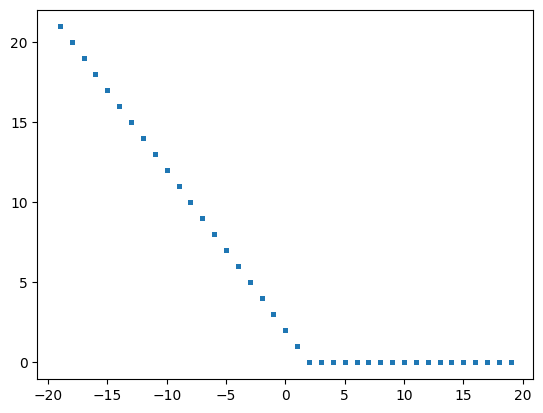

In [6]:
import matplotlib.pyplot as plt

x1 = np.arange(20)
x2 = np.arange(20)
X1, X2 = np.meshgrid(x1, x2)
X1, X2 = X1.flatten(), X2.flatten()

# If y=1 then it assumed the first input should be ranked higher (have a larger value) than the second input, and vice-versa for y=−1.
y = 1

margin = 2

xs = []
ys = []

for n in X1:
    for m in X2:
        diff = n-m
        loss = max(0, -y*(n - m) + margin)

        xs += [diff]
        ys += [loss]

plt.figure()
plt.scatter(xs, ys, s=5)
plt.show()

In [7]:
def pairwise_loss(X, event, event_time, risk, margin=0.2):
    n = X.shape[0]
    pairwise_combinations = combinations(n)

    # Find mask
    first_of_pair, second_of_pair = pairwise_combinations.T
    valid_mask = False
    valid_mask |= ((event[first_of_pair] == 1) & (event[second_of_pair] == 1))
    valid_mask |= ((event[first_of_pair] == 1) & (event_time[first_of_pair] < event_time[second_of_pair]))
    valid_mask |= ((event[second_of_pair] == 1) & (event_time[second_of_pair] < event_time[first_of_pair]))

    # pariwise hinge loss
    direction = 2*(event_time[first_of_pair] > event_time[second_of_pair]).int() - 1
    margin_loss = F.relu(direction*(risk[first_of_pair] - risk[second_of_pair]).squeeze() + margin)
    return margin_loss[valid_mask]

In [8]:
import math


class PairwiseRankingNeuralNetwork(pl.LightningModule):

    def __init__(self,
                 margin):
        
        super().__init__()
        self._margin = margin
        self.model = ODSTPytorchEmbeddingModel(INPUT_DIM,
                                               OUTPUT_DIM,
                                               categorical_idcs,
                                               cat_sizes,
                                               cat_emb,
                                               'none',
                                               hidden_dim=64,
                                               dropout=0.05)
        self.targets = []
        
    def forward(self, x):
        x = self.model(x)
        return x
        
    def training_step(self, batch, batch_idx):
        idx, X, event, event_time = batch
        risk_score = self(X)
        loss = pairwise_loss(X, event, event_time, risk_score).sum()/X.shape[0]
        self.log('train_pairwise_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        idx, X, event, event_time = batch
        risk_score = self(X)
        self.targets.append([event_time, risk_score.detach(), event, idx])
        loss = pairwise_loss(X, event, event_time, risk_score).sum()/X.shape[0]
        self.log('val_pairwise_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        """
        At the end of the validation epoch, it computes and logs the concordance index
        """
        scci = self._calc_cindex()
        self.log("cindex", scci, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        """
        Calculate c-index accounting for each race_group or global.
        """
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        idx = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        val_idcs = pd.Series(idx, index=idx)
        scci = scci_metric(val_idcs, y_hat)
        return scci

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-4)
        WARMUP = 10
        
        def exp_warm_up(epoch):
            
            if epoch < WARMUP:
                return 1.0 - math.exp(-(epoch+1) / WARMUP)
            return 1
        
        lambda_scheduler = LambdaLR(optimizer, lr_lambda=exp_warm_up)
        annealing_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                            optimizer,
                            T_max=45,
                            eta_min=6e-4
                        )
        scheduler = SequentialLR(optimizer, schedulers=[lambda_scheduler, annealing_scheduler], milestones=[WARMUP])

        scheduler_config = {
            "scheduler": scheduler,
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [9]:
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar, StochasticWeightAveraging

In [10]:
class AddFeatures(IFeatureTransformer):
    @staticmethod
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        settings.combined_df['is_cyto_score_same'] = (settings.combined_df['cyto_score'] == settings.combined_df['cyto_score_detail']).astype(int)
        settings.categorical_col_names += ['is_cyto_score_same']
        settings.training_col_names += ['is_cyto_score_same']
        settings.combined_df['year_hct'] -= 2000
        return settings
    
    
settings = DataSciencePipelineSettings(train_csv_path,
                                        test_csv_path,
                                        target_col_name,
                                        categorical_col_names=categoricals
                                        )
transforms = [
            AddFeatures.transform,
            StandardScaleNumerical.transform,
            FillNullMeanValues.transform,
            OrdinalEncode.transform,
            ConvertObjectToCategorical.transform,
            # GenerateSurvivalTarget('kaplanmeier').transform
            ]

settings = reduce(lambda acc, func: func(acc), transforms, settings)
settings.update()

train, test_df = settings.update()
# test_df.drop(columns=settings.target_col, inplace=True)
X, y = train.drop(columns=settings.target_col_name), train[settings.target_col_name]

INPUT_DIM = len(settings.training_col_names)
OUTPUT_DIM = 1

cat_names = settings.categorical_col_names
cat_sizes = [int(x) for x in X[cat_names].nunique().values]
# cat_emb = cat_sizes#[int(np.ceil(np.sqrt(x+1))) for x in cat_sizes]
cat_emb = [16] * len(cat_sizes)
categorical_idcs = [X.columns.get_loc(col) for col in cat_names]

In [12]:
EPOCHS = 30
MAX_LR = 6e-2
WARMUP = 10

In [13]:
import random

def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed_all(seed)  # PyTorch GPU (all devices)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disables auto-tuning for convolutions

set_seed(42)  # Call this before training

In [16]:
kf = StratifiedKFold(5, shuffle=True, random_state=42)


for i, (train_idx, test_idx) in enumerate(kf.split(X, X['race_group'])):
    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    dl_train = create_dataloader(X_train, y_train, shuffle=True)
    dl_test = create_dataloader(X_test, y_test)

            
    model = ODSTPytorchEmbeddingModel(INPUT_DIM,
                                    OUTPUT_DIM,
                                    categorical_idcs,
                                    cat_sizes,
                                    cat_emb,
                                    'none',
                                    hidden_dim=64,
                                    dropout=0.05)


    # checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_pairwise_loss", save_top_k=1)

    # trainer = pl.Trainer(
    #     accelerator='cpu',
    #     max_epochs=5,
    #     log_every_n_steps=1,
    #     callbacks=[
    #         checkpoint_callback,
    #         LearningRateMonitor(logging_interval='epoch'),
    #         TQDMProgressBar(),
    #         StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=40, annealing_epochs=15)
    #     ],
    # )

    # model = PairwiseRankingNeuralNetwork(margin=0.2)
    # trainer.fit(model=model, train_dataloaders=dl_train, val_dataloaders=dl_test)

    # pred_risk = model.eval()(
    #     torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    # )

    # val_metric = scci_metric(X_test, pred_risk.detach().numpy())

    def warm_up(epoch):
        if epoch < WARMUP:
            return (epoch+1)/WARMUP
        return 1
    
    def exp_warm_up(epoch):
        if epoch < WARMUP:
            return 1.0 - math.exp(-(epoch+1) / WARMUP)
        return 1
    
    optimizer = torch.optim.Adam(model.parameters(), lr=MAX_LR, weight_decay = 0.0003)
    lambda_scheduler = LambdaLR(optimizer, lr_lambda=exp_warm_up)
    
    annealing_scheduler = CosineAnnealingWarmRestarts(optimizer, 30, 1, 1e-3, last_epoch=EPOCHS)
    scheduler = SequentialLR(optimizer, schedulers=[lambda_scheduler, annealing_scheduler], milestones=[WARMUP])
    
    print()
    writer = SummaryWriter()

    for e in range(EPOCHS):
        
        total_train_loss = 0
        print(f"Fold {i+1}, epoch: {e+1}", end=" ")
        model.train()
        for (idx, X_, event, event_time) in dl_train:
            risk_pred = model(X_)
            all_loss = pairwise_loss(X_, event, event_time, risk_pred)
            loss = all_loss.sum()/X_.shape[0]
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        scheduler.step()        
        print(f"Epoch {e+1}: Learning Rate = {scheduler.get_last_lr()}")

        model.eval()
        pred_risk = model(torch.tensor(X_test.to_numpy(), dtype=torch.float32))
        eval_metric = scci_metric(X_test, pred_risk.detach().numpy())

        print(f"stratified concordance: ", eval_metric)


Fold 1, epoch: 1 Epoch 1: Learning Rate = [0.010876154815321091]
stratified concordance:  0.5699778588984244
Fold 1, epoch: 2 Epoch 2: Learning Rate = [0.015550906759096927]
stratified concordance:  0.573266736147124
Fold 1, epoch: 3 Epoch 3: Learning Rate = [0.01978079723786164]
stratified concordance:  0.6202671673250658
Fold 1, epoch: 4 Epoch 4: Learning Rate = [0.023608160417241994]
stratified concordance:  0.6438797688409764
Fold 1, epoch: 5 Epoch 5: Learning Rate = [0.027071301834358415]
stratified concordance:  0.6482830107868618
Fold 1, epoch: 6 Epoch 6: Learning Rate = [0.030204881772515426]
stratified concordance:  0.6425292748698563
Fold 1, epoch: 7 Epoch 7: Learning Rate = [0.0330402621529667]
stratified concordance:  0.6445962081913171
Fold 1, epoch: 8 Epoch 8: Learning Rate = [0.03560582041556405]
stratified concordance:  0.6328376217963438
Fold 1, epoch: 9 Epoch 9: Learning Rate = [0.03792723352971346]
stratified concordance:  0.6523889313413689
Fold 1, epoch: 10 Epoch 

KeyboardInterrupt: 